In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ViT algorithm Overview

Consider an image $X = \{H \times W \times C\} \in \mathbb{R}^{H \times W \times C}$. Along the Height and Width dimensions, we divide the image into non-overlapping patches $(P, P)$. For example, suppose that the dimensions of the image are I = (256 X 256 X 3). We can split this image into the following collection of patches $\{p^1, \ldots, p^{256}\}$ where $p^i$ = (16 x 16 x 3). Note that the number of patches, denoted by superscript are 256. This follows from the geometry of the image. See figure below:



(700, 727)


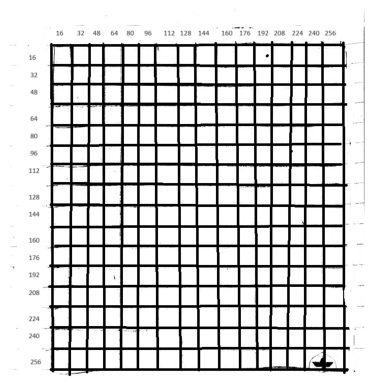

In [ ]:
image_path = '/content/drive/My Drive/ViT-codes/256x256_patchified.png'

from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img = Image.open(image_path)

# Check the size to confirm it's 256x256 as expected
print(img.size)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


After this, we flatten each patch to obtain a collection of vectors with each vector of dimension $P^2C$:

$$
\text{flat}(p^i) = x_p^i \in \mathbb{R}^{P^2 C}
$$


In total, we obtain $N = HW/p^{2}$


We concatenate the collection of vectors $x_p^i$ together to obtain all the collection of patches :

$$
P(x) = [x_p^1, x_p^2, \ldots, x_p^N]
$$

We now obtain embed each patch by linearly projecting each vector into an Embedding space:

$$
T(x) = P(x) E_t
$$

Where $E$ is a trainable matrix of dimensions $\mathbb{R}^{{P^2 C} \times d}$. The dimension $d$ corresponds to the hidden dimension of the transformer encoder.

At this point, it is a good to make an analogy of *tokens* with *patches*. Essentially, you can think of each patch as a token or word that you send into your NLP transformer. Notice how just like when we send tokens into the NLP transformer it has no idea about the syntax of language, ViT has no idea about the "ordering of each patch". So the ViT can pick up on the correct order of patches, we embed it with position embedding.

In case we are performing classification, we add a class token with the patches. It does not correspond to any real part of the image but serves as a placeholder for aggregating information across the entire image. Initially, it starts with no meaningful information but is updated through the layers of the transformer. As the input (image patches plus the class token) passes through the transformer layers, the class token aggregates global information from all the patches. By the time it reaches the output layer, the class token has captured a representation of the entire image. This representation is then used for classification or other tasks.


The rest of the algorithm is the same as in NLP. First, a learnable linear projection is applied to each token to obtain Query, Key, and Value. Next, calculate the similarity matrix, that is, $R \in \mathbb{R}^{(n+1) \times (n+1)}$, indicating the semantic relation between tokens through the dot product operation of Query and Key. The diagonal components of $R$ represent self-token relations, and the off-diagonal components represent intertoken relations:

$$
R(x) = xE_q (xE_k)^T
$$

Where $E_q \in \mathbb{R}^{d \times d_q}$ and $E_k \in \mathbb{R}^{d \times d_k}$ indicate learnable linear projections for Query and Key, respectively. And, $d_q$ and $d_k$ are the dimensions of Query and Key, respectively. Next, $R$ is divided by the square root of the Key dimension, and then the softmax function is applied to obtain the attention score matrix. Finally, calculate the self-attention, defined by the dot product of the attention score matrix and Value, as in:
$$
SA(x) = \text{softmax}\left(\frac{R}{\sqrt{d_k}}\right) \times E_v
$$
Where $E_v \in \mathbb{R}^{d \times d_v}$ is a learnable linear projection of Value, and $d_v$ is the Value dimension.

The entire architecture is depicted below with the three parts being:
1. Embeddings
2. Transformer Encoder
3. MLP Head


(623, 702)


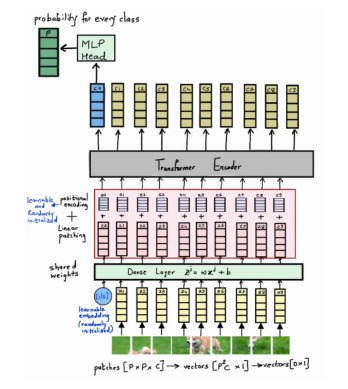

In [ ]:
image_path = '/content/drive/My Drive/ViT-codes/entire_transformer.png'

from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img = Image.open(image_path)

# Check the size to confirm it's 256x256 as expected
print(img.size)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Pytorch Tutorial


The following is a tutorial on vision transformers taken from the following [link](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html). It contains all the relevant code to create a transformer using pytorch. Lets see how.


# IMPORTS
Besides the usual suspects, notice that we have **pytorch lightning**. Pytorch lightning has a range of benefits which were explained by the creator itself on medium. Besides the high-level stuff, it provides a great progress bar and also gives information about the **total number of parameters**. This is something that we would require for our Student-Teacher setup.


In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 27.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [ ]:
import os

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR10
import math




`torch.backends.cudnn.deterministic = True:`

This setting forces cuDNN to use only deterministic algorithms. Normally, cuDNN might use non-deterministic algorithms to optimize calculations, which can lead to slight variations in results across different runs, even with the same inputs and model. Setting this to True ensures that the same inputs will always produce the same outputs.
This allows our results to be reproducible across runs.

`torch.backends.cudnn.benchmark = False:`

When set to True, this setting enables the cuDNN autotuner to find the most efficient algorithms for the current hardware configuration, which can enhance the performance of your model on fixed input sizes.

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", r"C:\Users\AWCD\OneDrive\Desktop\DL Project\Coding Perspective\\")

# Setting the seed
L.seed_everything(43)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


INFO: Seed set to 43
INFO:lightning.fabric.utilities.seed:Seed set to 43


# Loading CIFAR-10

In [ ]:

## DEFINING TRANSFORMS FOR THE DATASET


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.


train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

## loading Training,Test Validation Set. Note that we would not before augmentation on the validation set.
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)



Files already downloaded and verified
Files already downloaded and verified


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Files already downloaded and verified


In [ ]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Visualizing the CIFAR Dataset

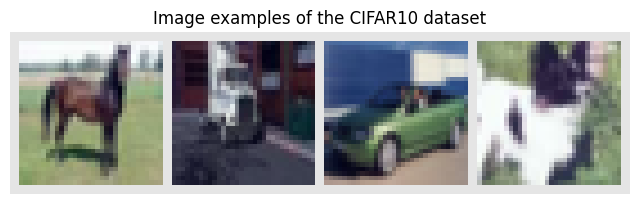

In [ ]:
# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

# Patchifying

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

# Scaled Dot Product (will implement in next tutorial)


Computes attention scores between queries and keys. It scales the dot product of queries and keys by the square-root of the dimensions of key. Finally, softmax is applied to normalize this into a probability distribuition.

#### Exploration:

*I was thinking, if we change the function from softmax to some other to capture more information across tokens or reduce computational complexity? Definitely explore this. Also, notice how this is softmax without temperature. What would happen if we change the temperature?*


In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)

    #if mask is not None:
        #attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    #print("shape of attention logits is ", attn_logits.shape)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

# Multihead Attention (abstracted from nn.MultiheadAttention)

In the pytorch tutorial, the author directly employ the **nn.MultiheadAttention**. Since in many of the future implementations, we would directly need to work with attention, we will employ the custom function that they refer to in tutorial 6 for the next exposition.  In multihead attention, we create the **K**, **Q**, **V** matrix, compute attention and output the final result.

# Transformer Block / Encoder

The attention block defines a single a Transformer block. This gives a single context vector $c_i$. Notice that a collection of these define our **transformer block** or **transformer encoder**. For example, in the next class Vision Tranformer, we define:

        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )

 Hence, multiple-attention blocks are created (equal to the num_layers) and these represent our transformer encoder.



In [ ]:
 class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)

        ### For our experiment, we ended up using nn.MultiheadAttention.
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        ### However, since we would be working with custom datasets. In the
        # next exposition we will carry out the experiment with our
        # custom Multihead.

        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        #print("shape of attention is ", self.attn(inp_x, inp_x, inp_x)[0].shape)
        #print("shape of original is ", x.shape)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

Besides the Transformer encoder, we need the following modules:

- A **linear projection layer** that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each M\times M patch independently as input.

- A **classification token** that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.

- **Learnable positional encodings** that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.

- **A MLP head** that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.

# Vision Transformer

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        #print("image after patchifying ", x.shape)

        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        #print("concatenating cls token ", x.shape)

        x = x + self.pos_embedding[:, : T + 1]
        #print("size of position embedding" , self.pos_embedding.shape)


        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)


        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

# Testing a Sample Through our Model



In [ ]:
random_image_tensor = torch.randn(1, 3, 32, 32)

model = VisionTransformer(
        embed_dim= 256,
        hidden_dim= 512,
        num_heads= 8,
        num_layers= 6,
        patch_size= 4,
        num_channels= 3,
        num_patches= 64,
        num_classes= 10,
        dropout= 0.2,
)
output = model(random_image_tensor)
print(output)

AttributeError: 'MultiheadAttention' object has no attribute 'shape'

# Our Entire Model


In [ ]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

# Experiments

In [ ]:
def train_model(**kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        accelerator="auto",
        devices=1,
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        model = ViT.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)  # To be reproducible
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

# Train Models

**Training on CPU** is hopeless. It would take too much time. You would have to utilize GPU for this task. 180 epochs on CPU would take easy 12 hours. On GPU its merely a 30-40 minutes game. I have already carried out the training in GPU. You can access it. The results were the following:

`ViT results {'test': 0.7599999904632568, 'val': 0.765999972820282}`

Notice that the model takes longer time to train and has a very large number of parameters (3.2 M)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params | In sizes        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=180` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=180` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.7599999904632568, 'val': 0.765999972820282}


# Analysis of the number of Paramters

Lets analyze the number of parameters in our model. Initially, we have an a (3 x 32 x 32) input. We transform this input into (4 x 4 x 3) patches. After flattening, the dimensionality is 48. We embed this 48 dimensional patch into 256 embeded dimensions.

1. **CLS Token Parameters**

- Now, the tokens are inputs and we do not learn it. What is learned however is the **cls-token** that interacts with these tokens. The dimensionsionality of the cls token is 256.

2. **Learnable Positional Embeddings Parameter**

- We have a total of 64 tokens. Since each token is of dimension 256, in total, the number of inputs is 64 x 256 = 16384. Now, we add **learnable positional embeddings** of the same dimension as these. Interestingly in NLP, these positional embeddings are deterministic. Why is that? Explore what these positional encoding in ViTs are actually doing.

3. **Embedding Matrix E Parameters**

- Now, the matrix **E** that maps the 48 dimensional tokens to 256 has the dimensionality (48 x 256)  = 12288.

4. **Transformer Block Parameters**

- The attention mechanism now splits the embedding dimensions of 256 across 3 each for the matrix Q, K, and V. Since each matrix Q, K, V is a square matrix of (256 x 256) and in total we have 3, then the total number of parameters for this step are the following: 256 x 256 x 3 = **196608**. In total, the biases with these matrices are 756. Notice that since we are performing multi-head attentions with 8 heads, these weights are actually being divided into 256/8 = 32 and then a (32 x 32) K, Q, V matrix is being computed. We then take all the ouputs and concatenate them. This is done by a matrix that takes parts from all the different heads and concatenates them together and is denoted by **256 x 256 = 65536**. We then move to feedforward layer. We go from **256 x 512 = 131072 parameters** to **512 x 256 = 131072** parameters. In total, the transformer block has the (196608 + 131072 + 131072) = 458752 parameters.

5. **Transformer Encoder**

- In total there are six transformer blocks so (458752 x 6) = 2.7 M parameters are present in the encoder. *seesh*.

6. **MLP Head**

- We go from 256 x 10 = 2560 parameters.



In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+------------------------------------+------------+
|              Modules               | Parameters |
+------------------------------------+------------+
|             cls_token              |    256     |
|           pos_embedding            |   16640    |
|         input_layer.weight         |   12288    |
|          input_layer.bias          |    256     |
| transformer.0.layer_norm_1.weight  |    256     |
|  transformer.0.layer_norm_1.bias   |    256     |
| transformer.0.attn.in_proj_weight  |   196608   |
|  transformer.0.attn.in_proj_bias   |    768     |
| transformer.0.attn.out_proj.weight |   65536    |
|  transformer.0.attn.out_proj.bias  |    256     |
| transformer.0.layer_norm_2.weight  |    256     |
|  transformer.0.layer_norm_2.bias   |    256     |
|   transformer.0.linear.0.weight    |   131072   |
|    transformer.0.linear.0.bias     |    512     |
|   transformer.0.linear.3.weight    |   131072   |
|    transformer.0.linear.3.bias     |    256     |
| transforme

3195146